# Grundlagen von Scikit-Learn und Machine Learning
Nachdem Sie letztes Mal einige der Grundlegenden Data Science-Bibliotheken in Python kennengelernt haben, geht es heute um Visualisierungen des Lernerfolgs. Kurz als Rekapitulation:

- Python ist unsere Programmiersprache und bietet Funktionen, Listen, For-Schleifen etc. Keyword-Argumente sind wichtig, sowie das Aufrufen von Methoden.
- Numpy und Pandas sind Pakete für Container von Daten: `np.array` und `pd.DataFrame`. 
- Matplotlib erstellt Visualisierungen: `plt.plot(x,y)`

In dieser Übung wollen wir eine erste Kaggle-Eingabe vornehmen. Dazu laden wir die Daten, trainieren einen Scikit-Learn-Klassifikator und erstellen die benötigte `submission.csv`-Datei. Sie lernen hier auch bereits Validierungskurven kennen- Visualisierungen welche helfen, die Hyperparameterwerte der Klassifikatoren sinnvoll und informiert zu wählen.

# Hilfscode (Details später)
Für den Moment überlesen Sie vielleicht diesen Abschnit erst mal. Vielleicht verstehen Sie schon was da passiert?

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
def import_data():
    """
    Lade die Daten aus dem Kaggle-Competition-Verzeichnis, und erstelle die X und y-Variablen (Features und Zielvariable)
    """
    dftrain = pd.read_csv('/kaggle/input/titanic-privat/train.csv',sep=',',index_col='Id')
    Xtest = pd.read_csv('/kaggle/input/titanic-privat/test.csv',sep=',',index_col='Id')
    Xtrain = dftrain.drop('survived',axis=1)
    ytrain = dftrain.survived
    return Xtrain, ytrain, Xtest

def data_cleansing_and_preprocessing(Xtrain,Xtest):
    """
    Vorverarbeitung: Feature Selection, Preprocessing (DecisionTrees verstehen nur nummerische Features)
    Rückgabe: Xtrain und Xtest
    """
    Xtrain['sex'] = Xtrain.sex.fillna(Xtrain['sex'].mode()[0])
    Xtest['sex'] = Xtest.sex.fillna(Xtrain['sex'].mode()[0])
    del Xtrain['cabin']
    del Xtrain['ticket']
    del Xtrain['name']
    del Xtest['cabin']
    del Xtest['ticket']
    del Xtest['name']
    numerische_features = ['fare','age']
    qualitative_features = ['pclass','sex','sibsp','parch','embarked']#,'ticket','cabin'
    
    imp_n = SimpleImputer(strategy = 'median')
    imp_n.fit(Xtrain[numerische_features])
    imp_q = SimpleImputer(strategy = 'most_frequent')
    imp_q.fit(Xtrain[qualitative_features])
    
    Xtrain[qualitative_features] = imp_q.fit_transform(Xtrain[qualitative_features])
    Xtrain[numerische_features] = imp_n.fit_transform(Xtrain[numerische_features])
    Xtest[qualitative_features] = imp_q.transform(Xtest[qualitative_features])
    Xtest[numerische_features] = imp_n.transform(Xtest[numerische_features])
    
    le1 = LabelEncoder()
    Xtrain['sex'] = le1.fit_transform(Xtrain['sex'])
    Xtest['sex'] = le1.transform(Xtest['sex'])

    le2 = LabelEncoder()

    Xtrain['embarked'] = le2.fit_transform(Xtrain['embarked'])
    Xtest['embarked'] = le2.transform(Xtest['embarked'])
    
    return Xtrain,Xtest

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

def plot_validation_curve(Xtrain,ytrain,cv=10,clf=None):
    """
    Zeichne eine Validierungskurve für clf (oder einen Entscheidungsbaum, wenn clf nicht angegeben wird).
    """
    if clf is None:
        clf = DecisionTreeClassifier()
    param_range = np.logspace(0, 3, 50)
    train_scores, test_scores = validation_curve(
        clf, Xtrain, ytrain, param_name="max_depth", param_range=param_range,cv=cv,scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title(f"Parameterkurve für max_depth\nTitanic-Datensatz mit Entscheidungsbaum,cv={cv}")
    plt.xlabel(r"max_depth")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="lower left")

Versuchen Sie, die nächsten Zeilen zu verstehen. Grob ist wohl klar was passiert. Aber z.B. die Grössen der Arrays (im Attribut `.shape` hinterlegt) sind instruktiv: 

In [2]:
Xtrain, ytrain, Xtest = import_data()

In [3]:
Xtrain.shape        # Vorschlag: entkommentieren Sie das
                    # Antwort: Die Trainingsdaten (Xtrain) bestehen aus 891 Zeilen und hat 10 Spalten.

(891, 10)

In [4]:
Xtrain,Xtest = data_cleansing_and_preprocessing(Xtrain,Xtest)

# Daten ansehen

Input files ansehen. Die ersten 5 Zeilen.

In [5]:
# Testdatensatz ansehen
Xtest.head()

,pclass,sex,age,sibsp,parch,fare,embarked
Id,,,,,,,
0,1.0,1,0.9167,1.0,2.0,151.5500,2
1,1.0,0,25.0000,1.0,2.0,151.5500,2
2,1.0,0,53.0000,2.0,0.0,51.4792,2
3,1.0,0,26.0000,0.0,0.0,78.8500,2
4,1.0,1,80.0000,0.0,0.0,30.0000,2


In [6]:
# Trainingsdatensatz ansehen
Xtrain.head()
# ytrain.head()

,pclass,sex,age,sibsp,parch,fare,embarked
Id,,,,,,,
419,1.0,0,29.0,0.0,0.0,211.3375,2
420,1.0,0,2.0,1.0,2.0,151.5500,2
421,1.0,1,30.0,1.0,2.0,151.5500,2
422,1.0,1,48.0,0.0,0.0,26.5500,2
423,1.0,0,63.0,1.0,0.0,77.9583,2


# 1. Versuch
Hier instanziieren und trainieren wir einen Entscheidungsbaum.

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=50)
clf.fit(Xtrain,ytrain)

DecisionTreeClassifier(max_depth=50)

**Übung**: Nehmen Sie an statt des Decision Trees einen Randomforest. Stellen Sie das Keyword-Argument `n_estimators` und `max_depth` passend ein. Wie gehen Sie dafür vor?

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Wir erstellen einen RandomForest mit 100 Entscheidungsbäumen und einer Tiefe von max. 5.
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
random_forest.fit(Xtrain, ytrain)
predictions = random_forest.predict(Xtest)

In [9]:
clf.score(Xtrain,ytrain)         # Was ist hier wohl mit Score gemeint? Raten Sie!

0.9775533108866442

In [10]:
random_forest.score(Xtrain,ytrain)

0.8484848484848485

**Frage**: Was ist hier mit Score gemeint?  
**Antwort**: Mit Score wird die Genauigkeit des erstellten Modells gemessen.   
Mithilfe des DecisionTreeClassifiers: 97.75%  
Mithilfe des RandomForestClassifiers: 84.84%

Wir erstellen mit der trainierten Klassifikator-Instanz `clf` eine Vorhersage:

In [11]:
# yhat = clf.predict(Xtrain)
yhat = random_forest.predict(Xtest)
yhat = yhat.astype('int')

**Übung**: Ist `yhat` ein eindimensionaler Vektor, oder eine zweidimensionale Matrix mit einer Zeile oder Spalte?  
**Übung**: Wieviele Elemente hat yhat?

In [12]:
yhat.shape, yhat.dtype, yhat.size

((418,), dtype('int64'), 418)

**Lösung**: yhat eindimensionaler Vektor, weil nur PassengerID aufgeführt werden und allenfalls die Daten überlebt oder nicht.  
**Lösung**: yhat hat 418 Elemente.

Als nächstes erstellen wir mit Pandas die Ausgabedatei. Ein Pandas Series-Objekt ist eine eindimensionale Datenstruktur, mit Namen und einem Index für jeden Wert. Die `.to_csv()`-Methode tut, was sie verspricht. Und hier auch genau in dem Format, wie wir es in den meisten Kaggle-Competitions brauchen. 

In [13]:
#yhat = np.array([1,1,0,1])
yhat = pd.Series(yhat,name='survived')
yhat.index.name='Id'
yhat.to_csv('submission.csv')

Als nächstes sollten Sie das Notebook Speichern, und die generierte submission.csv-Datei der Competition übermitteln.

Score 1. Versuch:

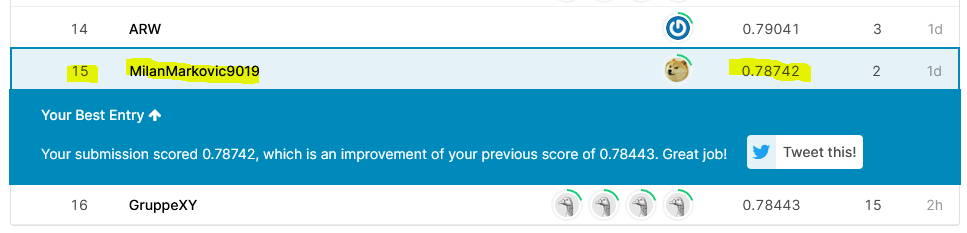

# 2. Versuch
Natürlich fragt es sich ob wir den richtigen Klassifikator mit den richtigen Hyperparameterwerten gewählt haben. Der folgende Code zeigt, wie wir verschiedene Hyperparameterwerte ausprobieren können. Für jeden Wert bestimmen wir einen Kreuzvalidierungs-Score: cv=10 heisst: Teile den Datensatz in 10 Teile, trainiere auf 9 davon und evaluiere auf dem verbleibenden (was 10 Mal gemacht werden kann). Mittle die erhaltenenen Scores und bestimme die Standardabweichung.

**Übung**: Welche Tiefe des Entscheidungsbaums wählen Sie?

In [14]:
from sklearn.model_selection import cross_val_score
scores_list=[]
for m in [1,2,3,4,5,6,7,8,9,10,11,12,20,200]:
    clf = DecisionTreeClassifier(max_depth=m)
    scores = cross_val_score(clf,Xtrain,ytrain,cv=10)
    scores_list.append(scores)
    print(f"Tiefe {m}:{np.mean(scores):1.3f}+/-{np.std(scores):1.3f}")

Tiefe 1:0.789+/-0.064
Tiefe 2:0.716+/-0.129
Tiefe 3:0.774+/-0.114
Tiefe 4:0.775+/-0.089
Tiefe 5:0.746+/-0.133
Tiefe 6:0.756+/-0.092
Tiefe 7:0.757+/-0.090
Tiefe 8:0.747+/-0.080
Tiefe 9:0.745+/-0.097
Tiefe 10:0.751+/-0.083
Tiefe 11:0.739+/-0.060
Tiefe 12:0.743+/-0.057
Tiefe 20:0.716+/-0.059
Tiefe 200:0.712+/-0.054


Die folgende Zeile ist nur eine von vielen Visualisierungsmöglichkeiten von Matplotlib. Verstehen Sie sie? Was bedeuten die orangen Balken, was die Whisker und die Kreise?

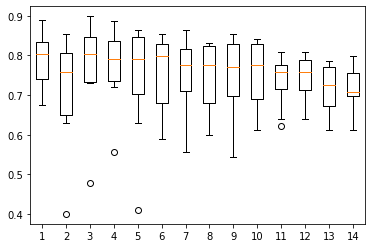

In [15]:
plt.boxplot(scores_list);

**Balken (Box)**: Entspricht dem Bereich, in dem die mittleren 50 % der Daten liegen.   
**Orange Linie**: Median. 50% der Daten liegen auf der linken Seite des Striches. Die anderen 50% auf der rechten Seite.   
**Whisker**: Fühler / Antenne. Definiert die Spannweite des Datensatzes. Max. 1.5fache des Interquartilsabstands.   
**Kreise**: Ausreisser. Datensätze, welche sich weiter als das 1.5fache des Interquartilsabstandes befinden.

Die Validierungskurve ist Ihre wichtigste Visualisierung, um einen Hyperparameterwert zu bestimmen. Insbesondere können Sie an diesem Plot ablesen, wann Overfitting beginnt (dort, wo die orange und violette Kurven auseinander gehen). Overfitting sehen Sie daran, dass mit grösserer Modellkomplexität (grössere `max_depth`) die Validierungsgenauigkeit abnimmt.

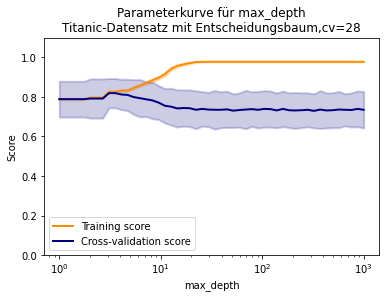

In [16]:
plot_validation_curve(Xtrain,ytrain, cv=28)

**zentrale Übung**: Wählen Sie in der nächsten Zeile einen geeigneten Wert für `max_depth`!

In [17]:
clf = DecisionTreeClassifier(max_depth=2) #hier geeigneten Wert wählen

**Antwort**:   
bei cv=28: Ab einer Tiefe des Entscheidungbaumes von 2 (oder auch 3) gehen die beiden Kurven am weitesten auseinander.   
Somit wäre 2 (oder auch 3) geeignete Werte um die max. Tiefe des Entscheidungsbaumes zu bestimmen.

In [18]:
clf.fit(Xtrain,ytrain)
yhat = clf.predict(Xtest).astype('int')
yhat

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [19]:
from sklearn import tree
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xtrain,ytrain)

print(tree.export_graphviz(clf,feature_names=Xtrain.columns.tolist(),class_names=['deceased','survived']))

digraph Tree {
node [shape=box] ;
0 [label="sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = deceased"] ;
1 [label="pclass <= 2.5\ngini = 0.375\nsamples = 308\nvalue = [77, 231]\nclass = survived"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="fare <= 22.0\ngini = 0.142\nsamples = 169\nvalue = [13, 156]\nclass = survived"] ;
1 -> 2 ;
3 [label="gini = 0.353\nsamples = 35\nvalue = [8, 27]\nclass = survived"] ;
2 -> 3 ;
4 [label="gini = 0.072\nsamples = 134\nvalue = [5, 129]\nclass = survived"] ;
2 -> 4 ;
5 [label="fare <= 23.35\ngini = 0.497\nsamples = 139\nvalue = [64, 75]\nclass = survived"] ;
1 -> 5 ;
6 [label="gini = 0.474\nsamples = 119\nvalue = [46, 73]\nclass = survived"] ;
5 -> 6 ;
7 [label="gini = 0.18\nsamples = 20\nvalue = [18, 2]\nclass = deceased"] ;
5 -> 7 ;
8 [label="age <= 13.5\ngini = 0.308\nsamples = 583\nvalue = [472, 111]\nclass = deceased"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="sibs

**Zur Übung 2 Ihrer Abgabe:** Wählen Sie einen geeigneten Entscheidungsbaum `clf` (Tiefe 1 ist nicht unbedingt ideal...). Geben Sie den GraphViz-Output z.B. in [https://edotor.net/](https://edotor.net/) ein, und interpretieren Sie die Visualisierung.  
Gemäss `le1.classes_` (in `data_cleansing_and_preprocessing`) entspricht `sex=0` dem Wert `female`.


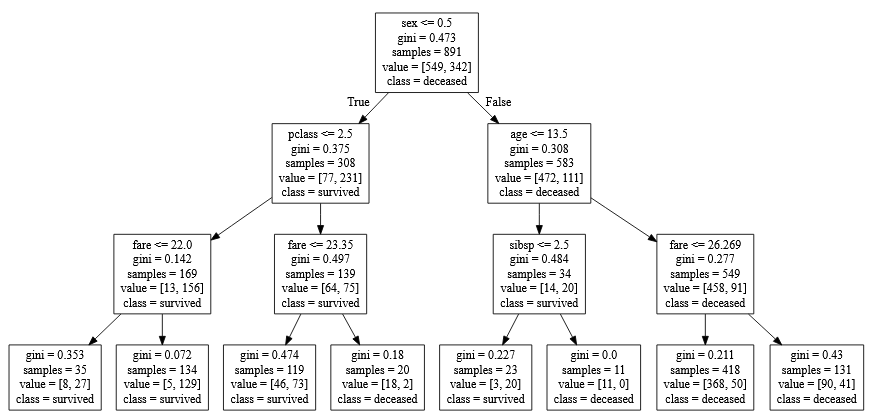

**Interpretation der Visualisierung**:    
In der Visualisierung oben lässt sich anhand des Desicion Trees erkennen, welche Typen von Passagieren das Unglück eher überleben und welche nicht.   
1. Absatz: Frauen (sex <=0.5) überleben tendenziell eher das Titanic Unglück.
2. Absatz. Linke Seite: Passagiere, weiblich, mit Klasse <= 2.5 (Eher 1. Klasse) überleben tendenziell eher das Unglück.
2. Absatz. Rechte Seite: Passagiere, männlich, mit Alter <= 13.5 (Kinder) überleben tendenziell eher das Unglück.
3. Absatz. Linke Seite: Passagiere, weiblich, mit Klasse <= 2.5 und mit Tarif <= 22.0 überleben tenenziell eher das Unglück.
3. Absatz. Rechte Seite: Kinder (<=13.5 Jahre), männlich, mit <= 2.5 Geschwistern überleben tendenziell eher das Unglück.

**Teilaufgabe A**: Welche Eigenschaften der Passagiere haben ein Überleben der Titanic-Katastrophe begünstigt?:   
Anhand des Entscheidungsbaumes in der oben gezeigten Visualisierung ist zu erkennen, dass weibliche Passagiere, vor allem diejenigen, welche in der 1. Klasse gereist sind und einen Passagiertarif von weniger als 22.00 gezahlt haben, eher das Unglück überlebt haben.
Zudem lässt sich in der rechten Hälfte des Entscheidungsbaumes festhalten, dass männliche Passagiere, vor allem Kinder (jünger als 13.5 Jahre) und mit weniger als 3 Geschwister eher am Leben geblieben sind.

**Teilaufgabe B**: Erstellen Sie eine textuelle Paraphrase, wie das Modell Vorhersagen generiert.   
Das vorliegende Modell generiert Vorhersagen mittels Entscheidungsbäumen. Mithilfe des Trainingsdatensatz wird ein Entscheidungsbaum kreeiert. Wie bereits oben beschrieben, werden je nach Feature (Geschlecht, Klasse, Alter, Anzahl Geschwister, Passagiertarif, usw.) einzelne Klassen gebildet. Der Gini-Index gibt dabei die Verteilung der Datensets bekannt.
Anhang des Entscheidungsbaumen lässt sich optisch gut erkennen, welche Eigenschaften ein Überleben nicht begünstigt haben. In diesem Fall wären es die Eigenschaften: männlich, älter als 14 Jahre, tiefere Klasse (3., 4. usw.)


**Teilaufgabe C**: Gehen Sie auf den Unterschied zwischen Korrelation und Kausalität ein. Was leistet diesbezüglich ein Entscheidungsbaum?   
Der Entscheidungsbaum gibt bekannt, dass diverse Variabeln miteinander korrelieren, jedoch aber nicht einen kausalen Zusammenhang aufweisen müssen. Beispielsweise ist, wie im Entscheidungsbaum angegeben, die Korrelation zwischen Anzahl Geschwister und Alter problematisch. Laut dem Entscheidungsbaum haben Kinder (männlich, jünger als 14 Jahre) eine höhere Überlebenschance, indem sie weniger Geschwister aufweisen. Haben diese beide Variablen wirklich einen kausalen Zusammenhang oder werden hier evtl. nicht weitere Faktoren berücksichtigt? Der kausale Zusammenhang lässt sich anhand des Entscheidungbaumes nicht abschliessend untersuchen.


**Übung**: Nehmen Sie ihr verbessertes Modell, erstellen Sie wieder eine `submission.csv`-Datei und submitten Sie sie an die Kaggle-Competition.

In [20]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest Classifier mit 100 Entscheidungsbäumen und einer max. Tiefe von 3.
random_forest = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)
random_forest.fit(Xtrain, ytrain)
predictions = random_forest.predict(Xtest)

In [21]:
random_forest.score(Xtrain,ytrain)

0.8170594837261503

In [22]:
yhat = random_forest.predict(Xtest)
yhat = yhat.astype('int')

In [23]:
yhat = pd.Series(yhat,name='survived')
yhat.index.name='Id'
yhat.to_csv('submission.csv')

Score 2. Versuch:

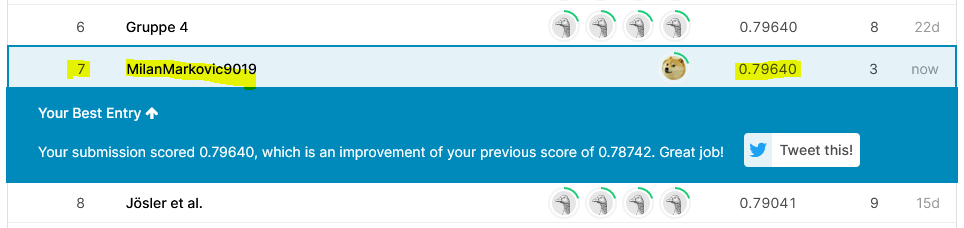